In [1]:
%matplotlib inline
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
from skimage import exposure

Developing a test script to find custom image calibration markers with opencv to eventually be used with plantCV      
Step 1: load the images in grayscale

In [2]:
bgr_img = cv2.imread('./X4-clino_2024_05_22_0055.JPG', cv2.IMREAD_COLOR)
# img = cv2.imread('./X4C4.JPG', cv2.IMREAD_GRAYSCALE)
# bgr_img = cv2.imread('./X4C4.JPG',cv2.IMREAD_COLOR)
img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
# template = cv2.imread('./colorcard_templat.png', cv2.IMREAD_GRAYSCALE)
bgr_template = cv2.imread('./colorcard_templat.png',cv2.IMREAD_COLOR)
rgb_template = cv2.cvtColor(bgr_template, cv2.COLOR_BGR2RGB)
template = cv2.cvtColor(bgr_template, cv2.COLOR_BGR2GRAY)
#Making syscalls to the filesystem twice as many times as neccessary, fix later

Step 2: Find countours in the image and then filter those contours to find the square ones that are most likely the color card      
Source: [plantCV github detect_color_card.py](https://github.com/danforthcenter/plantcv/blob/main/plantcv/plantcv/transform/detect_color_card.py) 

In [3]:
def _is_square(contour, min_size):
    """Determine if a contour is square or not.

    Parameters
    ----------
    contour : list
        OpenCV contour.

    Returns
    -------
    bool
        True if the contour is square, False otherwise.
    """
    return (cv2.contourArea(contour) > min_size and
            max(cv2.minAreaRect(contour)[1]) / min(cv2.minAreaRect(contour)[1]) < 1.27 and
            (cv2.contourArea(contour) / np.prod(cv2.minAreaRect(contour)[1])) > 0.8)


def _get_contour_sizes(contours):
    """Get the shape and size of all contours.

    Parameters
    ----------
    contours : list
        List of OpenCV contours.

    Returns
    -------
    list
        Contour areas, widths, and heights.
    """
    # Initialize chip shape lists
    marea, mwidth, mheight = [], [], []
    # Loop over our contours and size data about them
    for cnt in contours:
        marea.append(cv2.contourArea(cnt))
        _, wh, _ = cv2.minAreaRect(cnt)  # Rotated rectangle
        mwidth.append(wh[0])
        mheight.append(wh[1])
    return marea, mwidth, mheight

In [4]:
# threshold and findContours
gaussian = cv2.GaussianBlur(img, (11, 11), 0)
thresh = cv2.adaptiveThreshold(gaussian, 255, 1, cv2.THRESH_BINARY_INV, 51, 2)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours, keep only square-shaped ones
filtered_contours = [contour for contour in contours if _is_square(contour, 1000)]
# Calculate median area of square contours
target_square_area = np.median([cv2.contourArea(cnt) for cnt in filtered_contours])
# Filter contours again, keep only those within 20% of median area
# filtered_contours = [contour for contour in filtered_contours if (0.8 < (cv2.contourArea(contour) / target_square_area) < 1.2)]  #removed; too many squares inside the card
# Throw a fatal error if no color card found
if len(filtered_contours) == 0:
    fatal_error('No color card found')

Step 3: For each possible candidate contour, compare to template image to find the best match        
Source: Co-pilot conversation

In [5]:
# Variables to keep track of the best match
best_match_val = None
best_match_loc = None
best_match_dim = None

for contour in filtered_contours:
    # Compute the bounding rectangle for the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Resize the template to match the size of the contour
    resized_template = cv2.resize(template, (w, h))

    # Extract the region of interest from the main image
    roi = img[y:y+h, x:x+w]

    # Apply template matching
    result = cv2.matchTemplate(roi, resized_template, cv2.TM_CCOEFF)
    (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

    # If this match is better than the previous best match, update the best match
    if best_match_val is None or maxVal > best_match_val:
        best_match_val = maxVal
        best_match_loc = (x + maxLoc[0], y + maxLoc[1])
        best_match_dim = (w, h)

# Draw a rectangle around the best matched region
# cv2.rectangle(rgb_img, best_match_loc, (best_match_loc[0] + best_match_dim[0], best_match_loc[1] + best_match_dim[1]), (0, 255, 0), 10)

# # Display the image
# plt.imshow(rgb_img)
# plt.show()

Future steps to connect this to the plantCV pipeline:     
    -  Color correct the image yourself. PlantCV relies too heavily on the specific color card 

In [6]:
#Isolate the colorcard in the main image 
x = best_match_loc[0]
y = best_match_loc[1]
width = best_match_dim[0]
height = best_match_dim[1]

experimental_color_card = rgb_img[y:y+height, x:x+width]

#resize template to match experimental color card 
resized_template = cv2.resize(rgb_template, (width,height))


Color correction of the color cards through histogram matching      
Source: [sckit-image](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_histogram_matching.html)

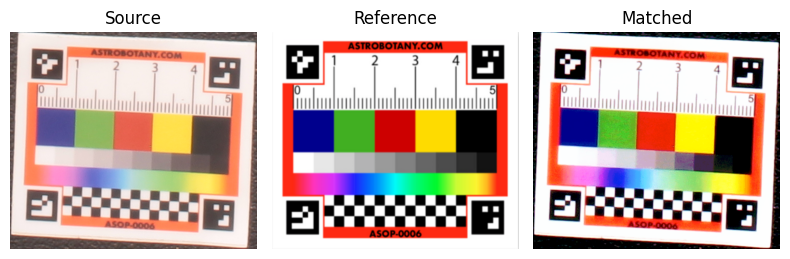

(417, 473, 3)


In [7]:
ccd = exposure.match_histograms(experimental_color_card, resized_template, channel_axis=-1)
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True
)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(experimental_color_card)
ax1.set_title('Source')
ax2.imshow(resized_template)
ax2.set_title('Reference')
ax3.imshow(ccd)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()
print(resized_template.shape)

This code uses the same principles as the histogram matching above to apply the same corrections to the entire image. An explanation from one user:     
"If you have a look at how match_histograms works under the hood you will find this very function being used. What it boils down to is the loop from line 73 to 76. This function is called for each of the three RGB channels, so you have to store the relevant quantile for each of the 3 channels. Or as mentioned before, keep passing your reference image to match_histograms, which is slightly more compututationally expensive. To circumvent that, store tmpl_quantiles and tmpl_values"
Source: [Stack overflow](https://stackoverflow.com/questions/70233645/color-correction-using-opencv-and-color-cards)

In [8]:
def _match_cumulative_cdf_mod(source, template, full):
    """
    Return modified full image array so that the cumulative density function of
    source array matches the cumulative density function of the template.
    """
    src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                           return_inverse=True,
                                                           return_counts=True)
    tmpl_values, tmpl_counts = np.unique(template.ravel(), return_counts=True)

    # calculate normalized quantiles for each array
    src_quantiles = np.cumsum(src_counts) / source.size
    tmpl_quantiles = np.cumsum(tmpl_counts) / template.size

    interp_a_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)

    # Here we compute values which the channel RGB value of full image will be modified to.
    interpb = []
    for i in range(0, 256):
        interpb.append(-1)

    # first compute which values in src image transform to and mark those values.

    for i in range(0, len(interp_a_values)):
        frm = src_values[i]
        to = interp_a_values[i]
        interpb[frm] = to

    # some of the pixel values might not be there in interp_a_values, interpolate those values using their
    # previous and next neighbours
    prev_value = -1
    prev_index = -1
    for i in range(0, 256):
        if interpb[i] == -1:
            next_index = -1
            next_value = -1
            for j in range(i + 1, 256):
                if interpb[j] >= 0:
                    next_value = interpb[j]
                    next_index = j
            if prev_index < 0:
                interpb[i] = (i + 1) * next_value / (next_index + 1)
            elif next_index < 0:
                interpb[i] = prev_value + ((255 - prev_value) * (i - prev_index) / (255 - prev_index))
            else:
                interpb[i] = prev_value + (i - prev_index) * (next_value - prev_value) / (next_index - prev_index)
        else:
            prev_value = interpb[i]
            prev_index = i

    # finally transform pixel values in full image using interpb interpolation values.
    wid = full.shape[1]
    hei = full.shape[0]
    ret2 = np.zeros((hei, wid))
    for i in range(0, hei):
        for j in range(0, wid):
            ret2[i][j] = interpb[full[i][j]]
    return ret2


def match_histograms_mod(inputCard, referenceCard, fullImage):
    """
        Return modified full image, by using histogram equalizatin on input and
         reference cards and applying that transformation on fullImage.
    """
    if inputCard.ndim != referenceCard.ndim:
        raise ValueError('Image and reference must have the same number '
                         'of channels.')
    matched = np.empty(fullImage.shape, dtype=fullImage.dtype)
    for channel in range(inputCard.shape[-1]):
        matched_channel = _match_cumulative_cdf_mod(inputCard[..., channel], referenceCard[..., channel],
                                                    fullImage[..., channel])
        matched[..., channel] = matched_channel
    return matched

In [9]:
color_corrected_image = match_histograms_mod(experimental_color_card, resized_template, rgb_img)

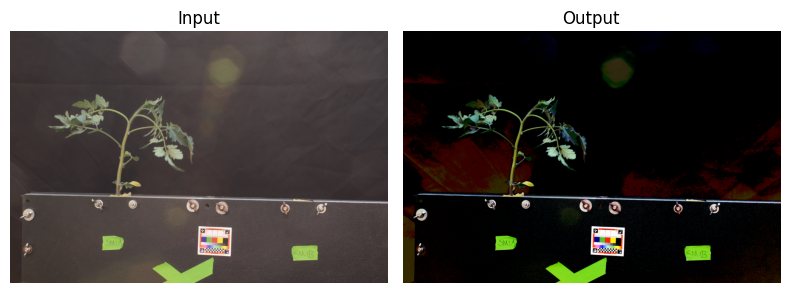

In [10]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 3), sharex=True, sharey=True
)
for aa in (ax1, ax2):
    aa.set_axis_off()

ax1.imshow(rgb_img)
ax1.set_title('Input')
ax2.imshow(color_corrected_image)
ax2.set_title('Output')

plt.tight_layout()
plt.show()

We're gonna continue with the plantCV pipeline that I was trying to rebuild. I just want to finish it. And there's no garuntee that this color accuracy pipeline will ever even be used. This just started out as a evaluation of plantCV anyways. 

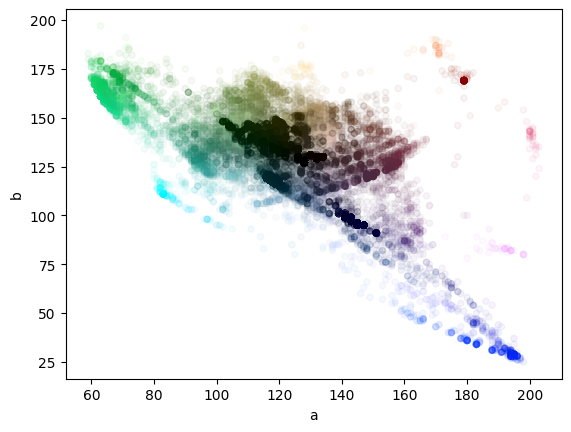

In [11]:
# pcv.visualize.pixel_scatter_plot doesn't have a implementation that just takes a np array as input. So we'll have to just save and reload 
# Assuming you have the color-corrected image stored in the variable "color_corrected_image"
pcv.print_image(color_corrected_image, './color_corrected_img_temp.png')
color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs = ["./color_corrected_img_temp.png"] , x_channel = "a", y_channel ="b" )


In [12]:
thresh1 = pcv.threshold.dual_channels(rgb_img = color_corrected_image, x_channel = "a", y_channel = "b", points = [(50,120),(140,135)], above=True)


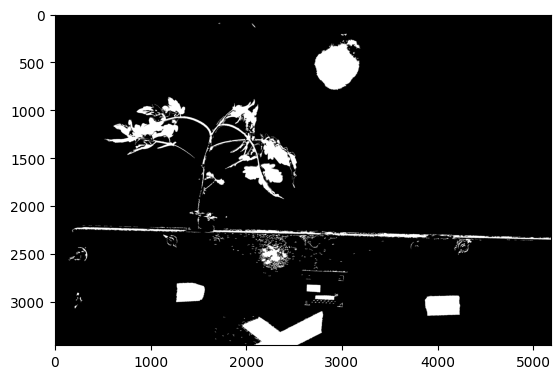

In [14]:
a_fill_image = pcv.fill(bin_img=thresh1, size=50)
a_fill_image = pcv.fill_holes(a_fill_image)

pcv.plot_image(a_fill_image)
pcv.print_image(a_fill_image, './a_tomato_plant_mask.jpg')

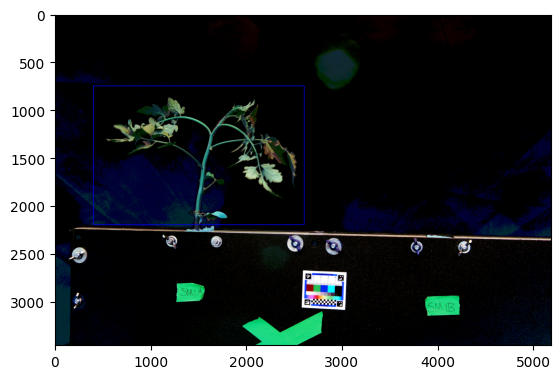

In [15]:
# Define the region of interest (ROI). This should include your plant, but not you color card or other things. 

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 

pcv.params.debug = "plot"

roi1 = pcv.roi.rectangle(img=color_corrected_image, x=400, y=750, h=1450, w=2200)

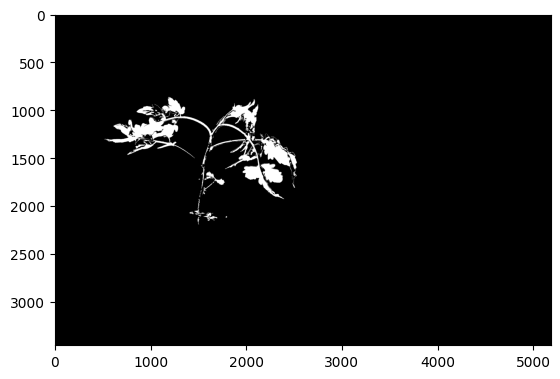

In [16]:
# Make a new filtered mask that only keeps the plant in your ROI and not objects outside of the ROI
# We have set to partial here so that if a leaf extends outside of your ROI it will still be selected. Switch to "cutto" if you have other plants that are getting selected on accident

# Inputs:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

kept_mask  = pcv.roi.filter(mask=a_fill_image, roi=roi1, roi_type='partial')

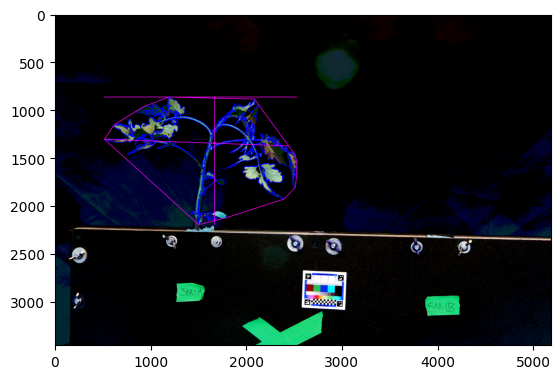

In [21]:
############### Analysis ################ 
  
# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 

analysis_image = pcv.analyze.size(img=color_corrected_image, labeled_mask=kept_mask)
pcv.print_image(analysis_image, './analysis_image.jpg')

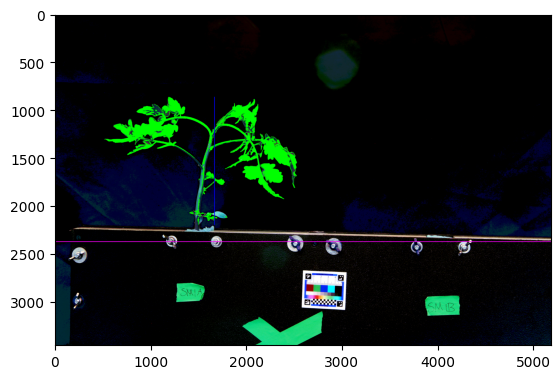

In [18]:
# Shape properties relative to user boundary line (optional). This is useful if your plant is hanging below the pot and you want height from the top of the pot.
# Set your line_position by finding the x-value at the top of the pot, hover your cursor to get that value

# Inputs:
#   img - RGB or grayscale image data 
#   obj - Single or grouped contour object 
#   mask - Binary mask of selected contours 
#   line_position - Position of boundary line (a value of 0 would draw a line 
#                   through the bottom of the image) 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

boundary_image = pcv.analyze.bound_horizontal(img=color_corrected_image,labeled_mask=kept_mask, 
                                               line_position=2380, label="default")

In [19]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   colorspaces - 'all' (default), 'rgb', 'lab', or 'hsv'
#                 This is the data to be printed to the SVG histogram file  
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)

color_histogram = pcv.analyze.color(rgb_img=color_corrected_image, labeled_mask=kept_mask, colorspaces='rgb', label="default")



alt.FacetChart(...)

In [20]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 

#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename="plantcv_results.json")